In [288]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_predict, cross_validate, GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

import warnings
warnings.filterwarnings('ignore')

import shap
shap.initjs()


df_normal_quality = pd.read_csv('dataframes/df_normal_quality.csv', index_col= 0).reset_index(drop = True)
y = df_normal_quality.SalePrice
X = df_normal_quality.drop(['SalePrice', 'PID'], axis =1).copy()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)
numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 2)

# Lasso
## Tuned with Optuna 

# KEEP THIS ONE

In [165]:
# categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")               

# numerical_preprocessor = RobustScaler()


# preprocessor = ColumnTransformer(
#     [
#         ("robust_scaler", numerical_preprocessor, numerical_columns),
#         ("one-hot-encoder", categorical_preprocessor, categorical_columns),
#     ]
# )

# lasso_pipe = Pipeline(steps=[("Preprocess", preprocessor), 
#                              ("Regressor", TransformedTargetRegressor(regressor = Lasso(alpha = 0.00030733929099045147),
#                                                                 func =np.log, inverse_func=np.exp))])

# scores = cross_val_score(lasso_pipe, X, y, cv = kf, error_score='raise')

# print('score', scores.mean())
# print('standard deviation', scores.std())

# lasso_pipe.fit(X,y)

# predictions = lasso_pipe.predict(X)
# print('predicted prices', predictions)
# mae = mean_absolute_error(y, predictions)
# print('Mean Absolute Error:', mae)
# mpv = predictions.mean()
# print ('Mean Predicted Home Value', mpv)
# mhv = y.mean()
# print ('Mean  Home Value', mhv)


score 0.9508124989217249
standard deviation 0.004995040204432598
predicted prices [125417.29914791 130118.74949454 115891.54733895 ... 153058.38303178
 224554.74105895 223794.23727269]
Mean Absolute Error: 10280.912930379654
Mean Predicted Home Value 172914.8587998538
Mean  Home Value 173427.01285897984


In [284]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")               

numerical_preprocessor = RobustScaler()

log_y = np.log(y)

preprocessor = ColumnTransformer(
    [
        ("robust_scaler", numerical_preprocessor, numerical_columns),
        ("one-hot-encoder", categorical_preprocessor, categorical_columns),
    ]
)

lasso_pipe = Pipeline(steps=[("Preprocess", preprocessor), 
                             ("Regressor",  Lasso(alpha = 0.00030733929099045147))])

scores = cross_val_score(lasso_pipe, X, log_y, cv = kf, error_score='raise')

print('score', scores.mean())
print('standard deviation', scores.std())

lasso_pipe.fit(X, log_y)

log_predictions = lasso_pipe.predict(X)
predictions = np.exp(log_predictions)
print('predicted prices', predictions)
mae = mean_absolute_error(y, predictions)
print('Mean Absolute Error:', mae)
mpv = predictions.mean()
print ('Mean Predicted Home Value', mpv)
mhv = y.mean()
print ('Mean  Home Value', mhv)

score 0.9430537707051151
standard deviation 0.009629050966039361
predicted prices [125417.29914791 130118.74949454 115891.54733895 ... 153058.38303178
 224554.74105895 223794.23727269]
Mean Absolute Error: 10280.912930379654
Mean Predicted Home Value 172914.8587998538
Mean  Home Value 173427.01285897984


In [197]:
log_predictions.mean()

11.997287510398447

## Lasso feature Importance 

In [4]:
lasso_pipe.fit(X, y)

# Extracting feature importances
# Get the coefficients from the Lasso model
lasso_regressor = lasso_pipe.named_steps['Regressor'].regressor_
coefficients = lasso_regressor.coef_

# Get the feature names after preprocessing
transformed_feature_names = lasso_pipe.named_steps['Preprocess'].get_feature_names_out()

# Combine the feature names and coefficients into a DataFrame
feature_importance_lasso = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': coefficients})

# Sort the DataFrame by importance
feature_importance_lasso = feature_importance_lasso.sort_values(by='Importance', ascending=False)


feature_importance_lasso['Feature'] = feature_importance_lasso['Feature'].str.replace('robust_scaler__', '', regex=False)
feature_importance_lasso['Feature'] = feature_importance_lasso['Feature'].str.replace('one-hot-encoder__', 'OHE__', regex=False)
feature_importance_lasso.head(5)

,Feature,Importance
0,GrLivArea,0.162424
9,OverallQual,0.113826
11,YearBuilt,0.095025
75,OHE__Neighborhood_Crawfor,0.092007
93,OHE__Neighborhood_Somerst,0.057523


## Lasso SHAP
### One hot encoded categories left apart

In [137]:
model = lasso_pipe.fit(X,y)
model

Pipeline(steps=[('Preprocess',
                 ColumnTransformer(transformers=[('robust_scaler',
                                                  RobustScaler(),
                                                  ['GrLivArea', 'MSSubClass',
                                                   'LotFrontage', 'LotArea',
                                                   'Alley', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LandSlope', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'ExterQual', 'ExterCond',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1', 'Bsmt...
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'MasVnrType', 'Foundation',
                                                   'Heating', 'CentralAir',
                                                   'Electrical', 'GarageType',
                                                   'GarageYN', 'PoolYN',
                                                   'Fence', 'SaleType',
                                                   'SaleCondition'])])),
                ('Regressor',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Lasso(alpha=0.00030733929099045147)))])

In [138]:
model.named_steps['Regressor'].regressor_

Lasso(alpha=0.00030733929099045147)

In [143]:
predictions.mean()

172914.8587998538

In [170]:
lasso_pipe.named_steps['Regressor'].regressor_

AttributeError: 'Lasso' object has no attribute 'regressor_'

In [285]:
model = lasso_pipe.fit(X, log_y)

explainer_lasso = shap.Explainer(lasso_pipe.named_steps['Regressor'],
                          masker = lasso_pipe.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_lasso = explainer_lasso(lasso_pipe.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = lasso_pipe.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_lasso = pd.DataFrame(shap_values_lasso.values, columns=transformed_feature_names)

bv = shap_values_lasso.base_values[0]
dollar_shap_values_lasso = np.exp(bv + shap_values_df_lasso) - np.exp(bv)
    
# Get rid of prefixes
dollar_shap_values_lasso.columns = dollar_shap_values_lasso.columns.str.replace('robust_scaler__', 
                                                                    '', 
                                                                    regex=False)
dollar_shap_values_lasso.columns = dollar_shap_values_lasso.columns.str.replace('one-hot-encoder__', 
                                                                    '', 
                                                                    regex=False)

df_lasso = pd.DataFrame(lasso_pipe.named_steps['Preprocess'].transform(X))
df_lasso.columns = dollar_shap_values_lasso.columns
df_lasso[numerical_columns] = X[numerical_columns]
df_lasso
# Create a shap.Explanation with scaled shap values and correct feature names 
exp_all_lasso = shap.Explanation(dollar_shap_values_lasso.values, 
                       np.exp(shap_values_lasso.base_values),
                       df_lasso)

TypeError: 'Lasso' object is not callable

In [199]:
bv

11.97224547650507

In [198]:
np.exp(bv)

158299.71990992117

In [172]:
(dollar_shap_values_lasso.sum(axis=1) + np.exp(shap_values_lasso.base_values) - predictions).mean()
#+ explanation.base_values - pred).max()

-7868.667792960638

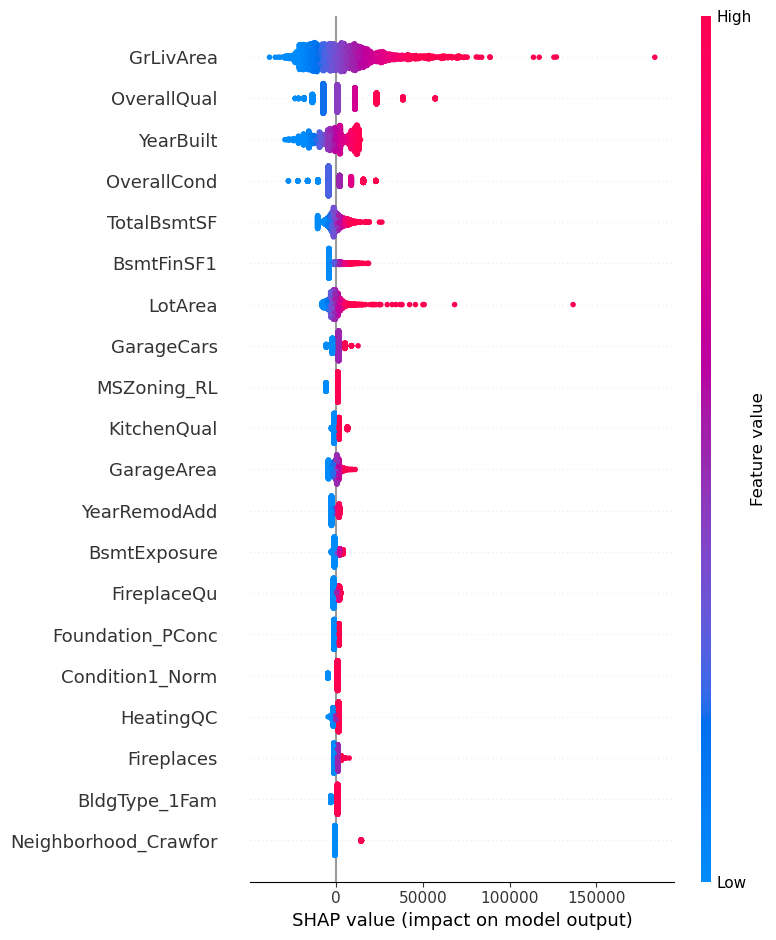

In [153]:
shap.summary_plot(exp_all_lasso)

## Lasso SHAP
### Features combined 

In [88]:
# Create a SHAP explainer for the Lasso model
explainer_lasso_comb = shap.LinearExplainer(lasso_pipe.named_steps['Regressor'].regressor_,
                          masker = lasso_pipe.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_lasso_comb = explainer_lasso_comb(lasso_pipe.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = lasso_pipe.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_lasso_comb = pd.DataFrame(shap_values_lasso_comb.values, columns=transformed_feature_names)

# correct categorical prefixes so encoded variables can be combined"
categorical_prefixes = categorical_columns_selector(X)
categorical_prefixes = ["one-hot-encoder__" + word for word in categorical_prefixes]
categorical_prefixes

for prefix in categorical_prefixes:
    # Get columns that start with the prefix
    columns = [col for col in transformed_feature_names if col.startswith(prefix)]
    
    # Calculate mean SHAP value for these columns
    shap_values_df_lasso_comb[prefix] = shap_values_df_lasso_comb[columns].mean(axis=1)
    
    # Drop the individual encoded columns
    shap_values_df_lasso_comb.drop(columns=columns, inplace=True)

# find the base_value and use it to convert shap values back to dollars
# Use this to find the dollar value home with just that particular feature
# the subtract the bv of the home to see the exact value for that feature 
bv = shap_values_lasso_comb.base_values[0]
dollar_shap_values_lasso_comb = np.exp(bv + shap_values_df_lasso_comb) - np.exp(bv)
    
# Get rid of prefixes
dollar_shap_values_lasso_comb.columns = dollar_shap_values_lasso_comb.columns.str.replace('robust_scaler__', 
                                                                    '', 
                                                                    regex=False)
dollar_shap_values_lasso_comb.columns = dollar_shap_values_lasso_comb.columns.str.replace('one-hot-encoder__', 
                                                                    '', 
                                                                    regex=False)

# reorder X columns so the original values are in the same order as the shap df
X_new_order = list(numerical_columns) + list(categorical_columns)
X_new_order =X[X_new_order]

# Create a shap.Explanation with scaled shap values and correct feature names 
exp_lasso_comb = shap.Explanation(dollar_shap_values_lasso_comb.values, 
                       np.exp(shap_values_lasso_comb.base_values),
                       X_new_order)

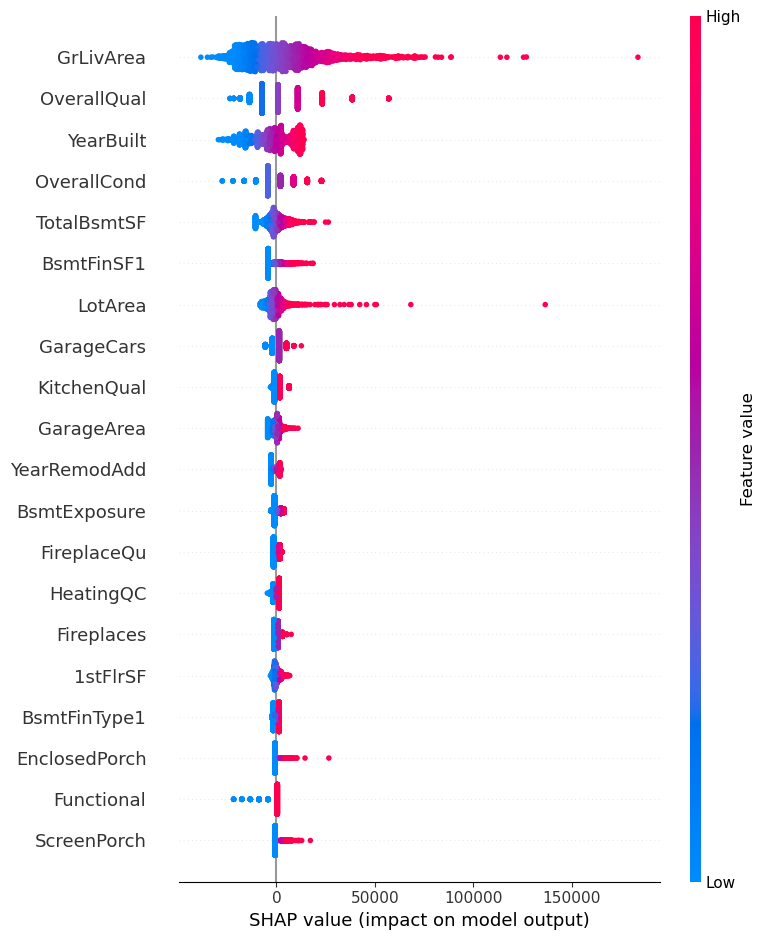

In [7]:
shap.summary_plot(exp_lasso_comb)

# XGB 
## Tuned with Optuna

In [8]:
categorical_preprocessor_OHE = OneHotEncoder(handle_unknown="ignore", drop = 'first')
categorical_preprocessor_O =  OrdinalEncoder(handle_unknown="use_encoded_value", 
                                           unknown_value= -1)
numerical_preprocessor = StandardScaler()

preprocessor_OHE = ColumnTransformer(
    [
        ("standard_scaler", numerical_preprocessor, numerical_columns),
        ("encoder", categorical_preprocessor_OHE, categorical_columns),
    ]
)

preprocessor_O = ColumnTransformer(
    [
        ("standard_scaler", numerical_preprocessor, numerical_columns),
        ("encoder", categorical_preprocessor_O, categorical_columns),
    ]
)


xgb =  XGBRegressor(max_depth= 3,
                    learning_rate= 0.03948737640519406,
                    subsample= 0.3203617673528298,
                    colsample_bytree= 0.9678010901635519,
                    n_estimators= 1000,
                    min_child_weight= 2)

xgb_pipe_OHE = Pipeline(steps=[("Preprocess", preprocessor_OHE), ("XGB", xgb)])

xgb_pipe_O = Pipeline(steps=[("Preprocess", preprocessor_O), ("XGB", xgb)])


scores_OHE = cross_val_score(xgb_pipe_OHE, X, y, cv = kf, error_score='raise')

scores_O = cross_val_score(xgb_pipe_O, X, y, cv = kf, error_score='raise')


print('XGB OneHot')
print('score', scores_OHE.mean())
print('standard deviation', scores_OHE.std())

print('         ')
print('XGB Ordinal')
print('score', scores_O.mean())
print('standard deviation', scores_O.std())


XGB OneHot
score 0.9525701317259067
standard deviation 0.003822619024286521
         
XGB Ordinal
score 0.95184668642212
standard deviation 0.0036899392855674687


## XGB feature imprtance 
### One hot encoder

In [9]:
xgb_pipe_OHE.fit(X, y)

# Extracting feature importances
# Get the coefficients from the Lasso model
#xgb_regressor = xgb_pipe.named_steps['Regressor'].regressor_
#feature_imp = xgb_regressor.feature_importances_
feature_imp = xgb_pipe_OHE.named_steps['XGB'].feature_importances_
# Get the feature names after preprocessing
transformed_feature_names = xgb_pipe_OHE.named_steps['Preprocess'].get_feature_names_out()

# Combine the feature names and coefficients into a DataFrame
feature_importance_xgb_oh = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': feature_imp})

# Sort the DataFrame by importance
feature_importance_xgb_oh = feature_importance_xgb_oh.sort_values(by='Importance', ascending=False)


feature_importance_xgb_oh['Feature'] = feature_importance_xgb_oh['Feature'].str.replace('standard_scaler__', '', regex=False)
feature_importance_xgb_oh['Feature'] = feature_importance_xgb_oh['Feature'].str.replace('encoder__', '', regex=False)
feature_importance_xgb_oh.head(10)

,Feature,Importance
9,OverallQual,0.178614
41,GarageCars,0.107363
14,ExterQual,0.056316
54,Bathrooms,0.046264
60,MSZoning_RM,0.034539
35,KitchenQual,0.027540
0,GrLivArea,0.026545
38,Fireplaces,0.023327
42,GarageArea,0.018785
24,TotalBsmtSF,0.016916


## XGB feature imprtance 
### Ordinal encoder

In [10]:
xgb_pipe_O.fit(X, y)

# Extracting feature importances
# Get the coefficients from the Lasso model
#xgb_regressor = xgb_pipe.named_steps['Regressor'].regressor_
#feature_imp = xgb_regressor.feature_importances_
feature_imp = xgb_pipe_O.named_steps['XGB'].feature_importances_
# Get the feature names after preprocessing
transformed_feature_names = xgb_pipe_O.named_steps['Preprocess'].get_feature_names_out()

# Combine the feature names and coefficients into a DataFrame
feature_importance_xgb_o = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': feature_imp})

# Sort the DataFrame by importance
feature_importance_xgb_o = feature_importance_xgb_o.sort_values(by='Importance', ascending=False)

feature_importance_xgb_o['Feature'] = feature_importance_xgb_o['Feature'].str.replace('standard_scaler__', '', regex=False)
feature_importance_xgb_o['Feature'] = feature_importance_xgb_o['Feature'].str.replace('encoder__', '', regex=False)

feature_importance_xgb_o.head(10)

,Feature,Importance
9,OverallQual,0.246695
41,GarageCars,0.121224
54,Bathrooms,0.067107
35,KitchenQual,0.042398
14,ExterQual,0.037956
0,GrLivArea,0.032138
38,Fireplaces,0.030368
72,GarageType,0.023609
24,TotalBsmtSF,0.023527
44,GarageCond,0.022935


## XGB SHAP
### One hot encoder

In [12]:
explainer_xgb_oh = shap.Explainer(xgb_pipe_OHE.named_steps['XGB'],
                          masker = xgb_pipe_OHE.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_xgb_oh = explainer_xgb_oh(xgb_pipe_OHE.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = xgb_pipe_OHE.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_xgb_oh = pd.DataFrame(shap_values_xgb_oh.values, columns=transformed_feature_names)

    
# Get rid of prefixes
shap_values_df_xgb_oh.columns = shap_values_df_xgb_oh.columns.str.replace('standard_scaler__', 
                                                                    '', 
                                                                    regex=False)
shap_values_df_xgb_oh.columns = shap_values_df_xgb_oh.columns.str.replace('encoder__', 
                                                                    '', 
                                                                    regex=False)

 94%|=================== | 2191/2333 [00:16<00:01]       

In [13]:
X_xgb = pd.DataFrame(xgb_pipe_OHE.named_steps['Preprocess'].transform(X))
X_xgb.columns = shap_values_df_xgb_oh.columns
X_xgb[numerical_columns] = X[numerical_columns]

exp_all_xgb_oh = shap.Explanation(shap_values_df_xgb_oh.values, 
                           shap_values_xgb_oh.base_values, 
                           X_xgb
                         )

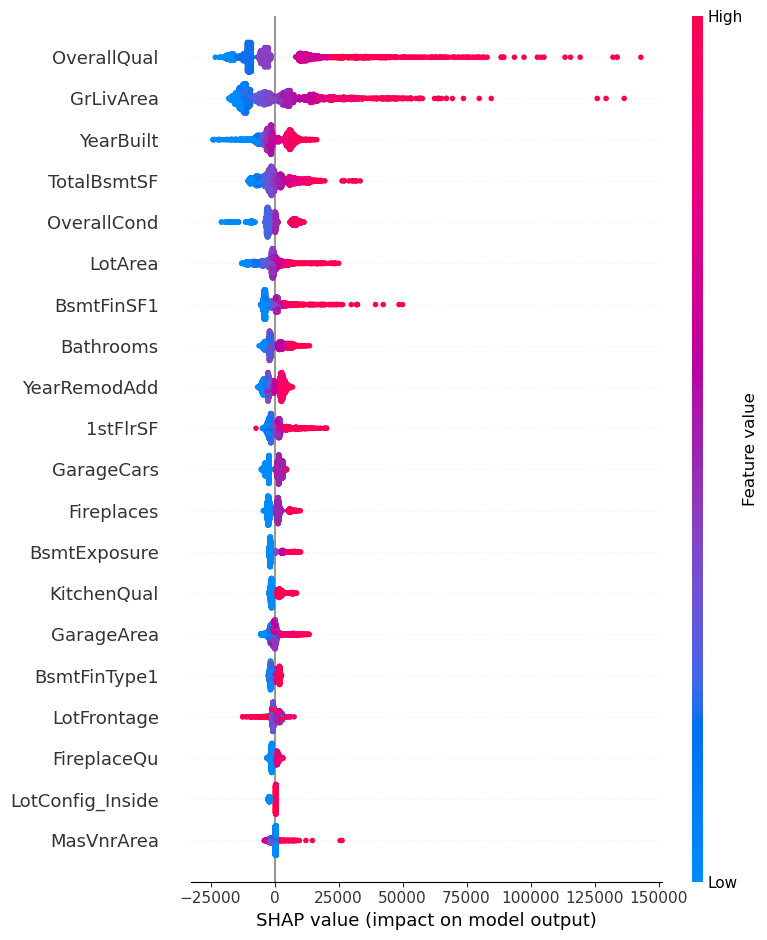

In [14]:
shap.summary_plot(exp_all_xgb_oh, max_display= 20)

## XGB SHAP
### Ordinal encoder

In [15]:
explainer_xgb_o = shap.Explainer(xgb_pipe_O.named_steps['XGB'],
                          masker = xgb_pipe_O.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_xgb_o = explainer_xgb_o(xgb_pipe_O.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = xgb_pipe_O.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_xgb_o = pd.DataFrame(shap_values_xgb_o.values, columns=transformed_feature_names)

shap_values_df_xgb_o.columns = shap_values_df_xgb_o.columns.str.replace('standard_scaler__', 
                                                                    '', 
                                                                    regex=False)
shap_values_df_xgb_o.columns = shap_values_df_xgb_o.columns.str.replace('encoder__', 
                                                                    '', 
                                                                    regex=False)


 95%|=================== | 2208/2333 [00:16<00:00]       

In [233]:
xgb =  XGBRegressor(max_depth= 3,
                    learning_rate= 0.03948737640519406,
                    subsample= 0.3203617673528298,
                    colsample_bytree= 0.9678010901635519,
                    n_estimators= 1000,
                    min_child_weight= 2)

model = xgb.fit(X[numerical_columns],y)
explainer = shap.Explainer(model)
shap_values = explainer(X[numerical_columns])

In [234]:
shap_values.base_values

array([173382.38, 173382.38, 173382.38, ..., 173382.38, 173382.38,
       173382.38], dtype=float32)

In [236]:
model.predict(X[numerical_columns]).mean()

173447.39

In [228]:
xgb_pipe_O.fit(X,y)

Pipeline(steps=[('Preprocess',
                 ColumnTransformer(transformers=[('standard_scaler',
                                                  StandardScaler(),
                                                  ['GrLivArea', 'MSSubClass',
                                                   'LotFrontage', 'LotArea',
                                                   'Alley', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LandSlope', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'ExterQual', 'ExterCond',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1', '...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.03948737640519406, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=3, max_leaves=None,
                              min_child_weight=2, missing=nan,
                              monotone_constraints=None, n_estimators=1000,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [229]:
xgb_pipe_O.predict(X).mean()

173466.72

In [224]:
shap_values_xgb_o.base_values

array([167258.75832795, 167258.75832795, 167258.75832795, ...,
       167258.75832795, 167258.75832795, 167258.75832795])

In [16]:
X_xgb_o = pd.DataFrame(xgb_pipe_O.named_steps['Preprocess'].transform(X))
X_xgb_o.columns = shap_values_df_xgb_o.columns
X_xgb_o[numerical_columns] = X[numerical_columns]
X_xgb_o

exp_all_xgb_o = shap.Explanation(shap_values_df_xgb_o.values, 
                           shap_values_xgb_o.base_values, 
                           X_xgb_o
                         )

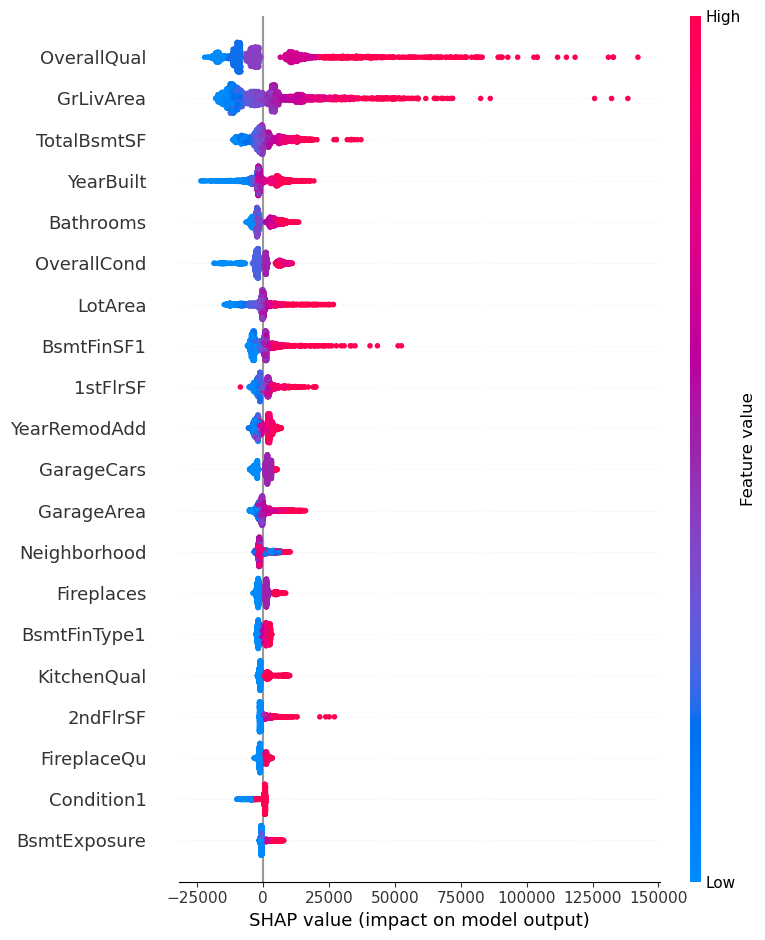

In [19]:
shap.summary_plot(exp_all_xgb_o, max_display= 20)


 # Lasso vs. XGB

In [30]:
xgb_pipe_OHE.fit(X,y)

Pipeline(steps=[('Preprocess',
                 ColumnTransformer(transformers=[('standard_scaler',
                                                  StandardScaler(),
                                                  ['GrLivArea', 'MSSubClass',
                                                   'LotFrontage', 'LotArea',
                                                   'Alley', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LandSlope', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'ExterQual', 'ExterCond',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1', '...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.03948737640519406, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=3, max_leaves=None,
                              min_child_weight=2, missing=nan,
                              monotone_constraints=None, n_estimators=1000,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [52]:
xgb_predictions = xgb_pipe_OHE.predict(X)
xgb_mae = mean_absolute_error(y, xgb_predictions)
import plotly.express as px
import pandas as pd

# Assuming X is a DataFrame and y, predictions are Series
# Combine y and predictions into a DataFrame for easy handling
data = pd.DataFrame({
    'GrLivArea': X['GrLivArea'],
    'OverallQual': X['OverallQual'],
    'Error': y - xgb_predictions
})

# Create the plot
fig = px.scatter(
    data, x='GrLivArea', y='Error',
    color=np.sqrt(X.OverallQual), 
    title=f'XGB: Living Area vs. Prediction Error<br><sup>Mean Absolute Error: ${xgb_mae:.2f}</sup>',
    labels={'GrLivArea': 'Above Ground Living Area (Square Feet)', 
            'Error': 'Error ($)', 
            'color': 'Overall Quality'}
)

# Add a horizontal line at y=0
fig.add_shape(type="line",
              x0=min(data['GrLivArea']), x1=max(data['GrLivArea']),
              y0=0, y1=0,
              line=dict(color="red", dash="dash"))

fig.update_layout(
    yaxis_range=[-100000, 100000]
)

# Show plot
fig.show()

In [53]:
lasso_predictions = lasso_pipe.predict(X)
lasso_mae = mean_absolute_error(y, lasso_predictions)
import plotly.express as px
import pandas as pd

# Assuming X is a DataFrame and y, predictions are Series
# Combine y and predictions into a DataFrame for easy handling
data = pd.DataFrame({
    'GrLivArea': X['GrLivArea'],
    'OverallQual': X['OverallQual'],
    'Error': y - lasso_predictions
})

# Create the plot
fig = px.scatter(
    data, x='GrLivArea', y='Error',
    color=np.sqrt(X.OverallQual), 
    title=f'Lasso: Living Area vs. Prediction Error<br><sup>Mean Absolute Error: ${lasso_mae:.2f}</sup>',
    labels={'GrLivArea': 'Above Ground Living Area (Square Feet)', 
            'Error': 'Error ($)',
            'color': 'Overall Quality'}
)

# Add a horizontal line at y=0
fig.add_shape(type="line",
              x0=min(data['GrLivArea']), x1=max(data['GrLivArea']),
              y0=0, y1=0,
              line=dict(color="red", dash="dash"))

# Show plot
fig.show()


In [36]:
# fig = px.scatter(
#     x=X.Neighborhood, 
#     y=shap_values_df_xgb_o.Neighborhood, 
#     color = np.sqrt(X.OverallQual),
#     labels={'x': 'Overall Quality', 'y': 'Neighborhood SHAP Values'},
#     title='Overall Quality vs Neighborhood SHAP Values'
# )

# # Show the plot
# fig.show()
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=X.Neighborhood,
    y=shap_values_df_xgb_o.Neighborhood,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.Neighborhood,
    y= dollar_shap_values_lasso_comb.Neighborhood,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Neighborhood SHAP Values',
    xaxis=dict(title='Neighborhood'),
    yaxis=dict(title='SHAP Values'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [33]:
import plotly.graph_objs as go

trace1 = go.Scatter(
    x= X.GrLivArea,
    y=shap_values_df_xgb_o.GrLivArea,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.GrLivArea,
    y= dollar_shap_values_lasso_comb.GrLivArea,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Living Area SHAP Values',
    xaxis=dict(title='Above Ground Living Area (Square Feet)'),
    yaxis=dict(title='SHAP Values'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [34]:
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=np.sqrt(X.OverallQual),
    y=shap_values_df_xgb_o.OverallQual,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= np.sqrt(X.OverallQual),
    y= dollar_shap_values_lasso_comb.OverallQual,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Overall Quality SHAP Values',
    xaxis=dict(title='Overall Quality'),
    yaxis=dict(title='SHAP Values'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [35]:
trace1 = go.Scatter(
    x=X.YearBuilt,
    y=shap_values_df_xgb_o.YearBuilt,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.YearBuilt,
    y= dollar_shap_values_lasso_comb.YearBuilt,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Year Built SHAP Values',
    xaxis=dict(title='Year Built'),
    yaxis=dict(title='SHAP Value'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

# Put predictions into dataframe 

In [91]:
df_predictions = df_normal_quality.copy()
df_predictions['Lasso'] = lasso_predictions
df_predictions['error_Lasso'] = df_predictions.SalePrice - df_predictions.Lasso
df_predictions['xgb'] = xgb_predictions
df_predictions['error_xgb'] = df_predictions.SalePrice - df_predictions.xgb
df_predictions[['SalePrice', 'Lasso',  'error_Lasso', 'xgb','error_xgb']]

,SalePrice,Lasso,error_Lasso,xgb,error_xgb
0,126000,125417.299148,582.700852,121696.250000,4303.750000
1,139500,130118.749495,9381.250505,134283.421875,5216.578125
2,124900,115891.547339,9008.452661,121595.359375,3304.640625
3,114000,105123.287031,8876.712969,105797.468750,8202.531250
4,227000,223707.350576,3292.649424,209003.250000,17996.750000
...,...,...,...,...,...
2328,121000,107056.493708,13943.506292,113421.500000,7578.500000
2329,139600,122895.059269,16704.940731,141674.984375,-2074.984375
2330,145000,153058.383032,-8058.383032,148440.640625,-3440.640625
2331,217500,224554.741059,-7054.741059,225128.843750,-7628.843750


In [92]:
trace1 = go.Scatter(
    x=df_predictions.loc[df_predictions.Neighborhood == 'NoRidge'].GrLivArea,
    y=df_predictions.loc[df_predictions.Neighborhood == 'NoRidge'].error_xgb,
    mode='markers',
    name='xgb'
)
trace2 = go.Scatter(
    x=df_predictions.loc[df_predictions.Neighborhood == 'NoRidge'].GrLivArea,
    y=df_predictions.loc[df_predictions.Neighborhood == 'NoRidge'].error_Lasso,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Sale Price vs. Predictions',
    xaxis=dict(title='Sale Price'),
    yaxis=dict(title='Predicted Price'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [222]:
df_predictions.loc[df_predictions.GrLivArea > 4000]

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,Fence,MoSold,YrSold,SaleType,SaleCondition,Bathrooms,Lasso,error_Lasso,xgb,error_xgb
807,528351010,4316,755000,60,RL,104.0,21535,Pave,0.0,2,...,NO,1,2007,WD,Normal,4.0,839574.083156,-84574.083156,739233.9375,15766.0625


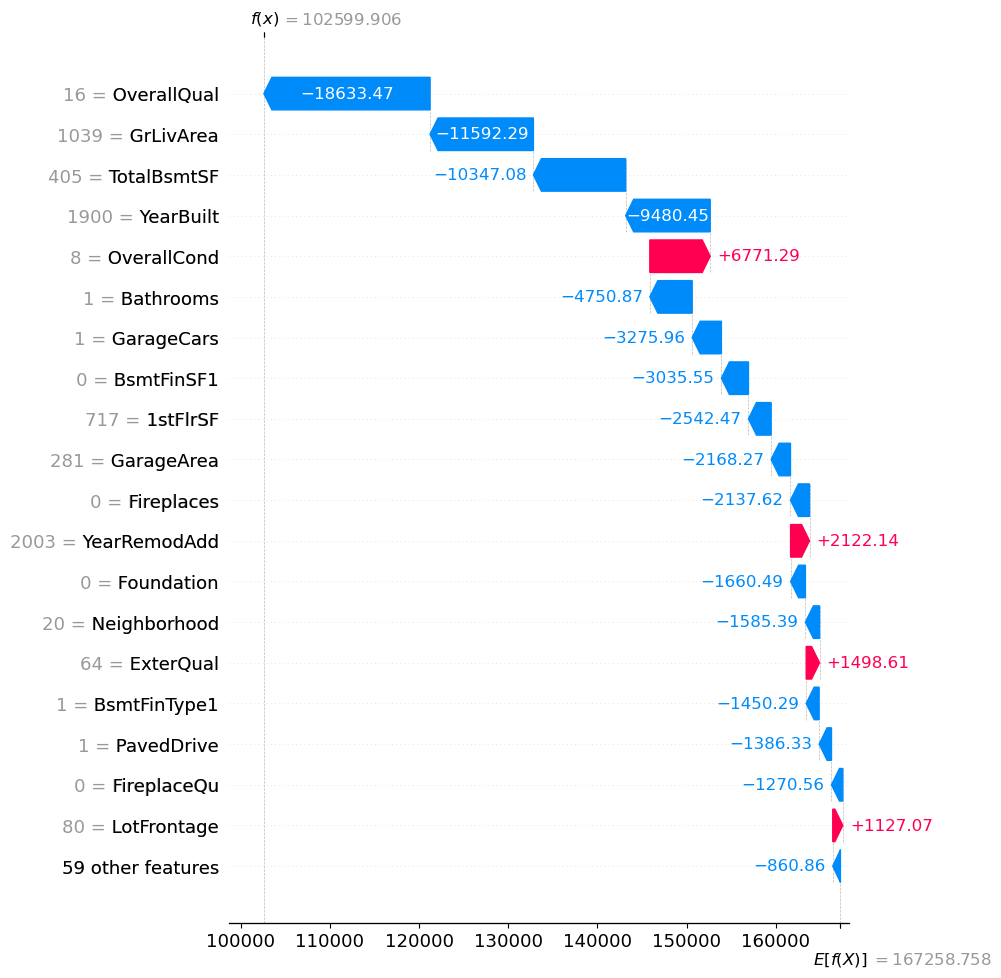

In [205]:
shap.waterfall_plot(exp_all_xgb_o[3], max_display= 20)

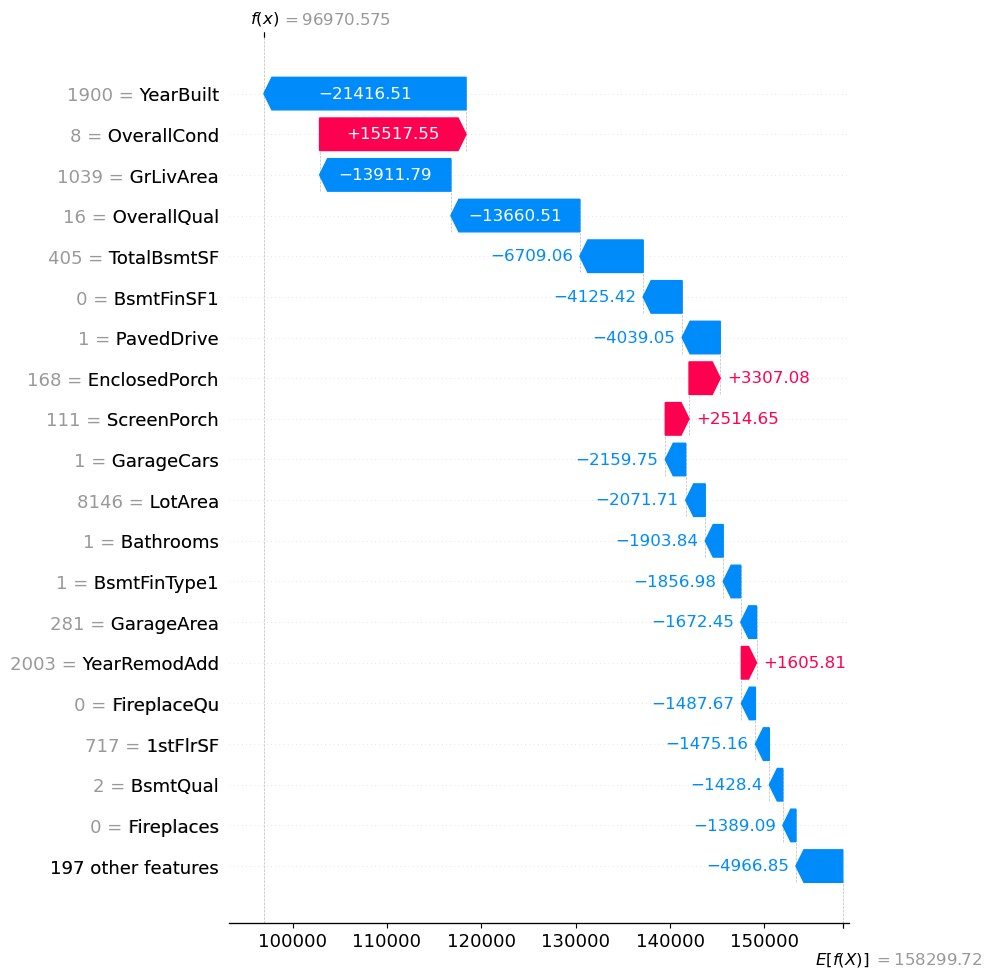

In [206]:
shap.waterfall_plot(exp_all_lasso[3], max_display= 20)

In [65]:
trace1 = go.Scatter(
    x=df_predictions.loc[df_predictions.OverallQual == 100].GrLivArea,
    y=df_predictions.loc[df_predictions.OverallQual == 100].error_xgb,
    mode='markers',
    name='xgb'
)
trace2 = go.Scatter(
    x=df_predictions.loc[df_predictions.OverallQual == 100].GrLivArea,
    y=df_predictions.loc[df_predictions.OverallQual == 100].error_Lasso,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Sale Price vs. Predictions',
    xaxis=dict(title='Sale Price'),
    yaxis=dict(title='Predicted Price'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [208]:
X[numerical_columns]

,GrLivArea,MSSubClass,LotFrontage,LotArea,Alley,LotShape,LandContour,Utilities,LandSlope,OverallQual,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolQC,MoSold,YrSold,Bathrooms
0,856,30,62.472926,7890,0.0,1,4,4,3,36,...,3,0,0,0,0,166,0.0,3,2010,2.0
1,1049,120,42.000000,4235,0.0,1,4,4,3,25,...,3,0,105,0,0,0,0.0,2,2009,3.0
2,1001,30,60.000000,6060,0.0,1,4,4,3,25,...,1,154,0,42,86,0,0.0,11,2007,1.0
3,1039,70,80.000000,8146,0.0,1,4,4,3,16,...,1,0,0,168,0,111,0.0,5,2009,1.0
4,1665,60,70.000000,8400,0.0,1,4,4,3,64,...,3,0,45,0,0,0,0.0,11,2009,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,952,30,70.105866,8854,0.0,1,4,4,3,36,...,2,0,98,0,0,40,0.0,5,2009,1.0
2329,1733,20,108.318076,13680,0.0,2,4,4,3,9,...,3,0,0,0,0,0,0.0,6,2009,2.0
2330,2002,90,82.000000,6270,0.0,1,2,4,3,25,...,3,0,0,0,0,0,0.0,8,2007,2.0
2331,1842,60,69.884162,8826,0.0,1,4,4,3,49,...,3,193,96,0,0,0,0.0,7,2007,3.5


NameError: name 'lasso' is not defined

Lasso(alpha=0.00030733929099045147)

In [219]:
model.predict(X[numerical_columns]).mean()

173427.01285897975

In [242]:
y.mean()

173427.01285897984

In [257]:
model

Ridge(alpha=1)

In [262]:
X_test.loc[X_test.GrLivArea > 4000]

,GrLivArea,MSSubClass,LotFrontage,LotArea,Alley,LotShape,LandContour,Utilities,LandSlope,OverallQual,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolQC,MoSold,YrSold,Bathrooms
807,4316,60,104.0,21535,0.0,2,4,4,3,100,...,3,382,50,0,0,0,0.0,1,2007,4.0


In [277]:
test = df_normal_quality.copy()


In [278]:
test.drop([807])

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,3SsnPorch,ScreenPorch,PoolYN,PoolQC,Fence,MoSold,YrSold,SaleType,SaleCondition,Bathrooms
0,909176150,856,126000,30,RL,62.472926,7890,Pave,0.0,1,...,0,166,no,0.0,NO,3,2010,WD,Normal,2.0
1,905476230,1049,139500,120,RL,42.000000,4235,Pave,0.0,1,...,0,0,no,0.0,NO,2,2009,WD,Normal,3.0
2,911128020,1001,124900,30,C (all),60.000000,6060,Pave,0.0,1,...,86,0,no,0.0,NO,11,2007,WD,Normal,1.0
3,535377150,1039,114000,70,RL,80.000000,8146,Pave,0.0,1,...,0,111,no,0.0,NO,5,2009,WD,Normal,1.0
4,534177230,1665,227000,60,RL,70.000000,8400,Pave,0.0,1,...,0,0,no,0.0,NO,11,2009,WD,Normal,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,903205040,952,121000,30,RL,70.105866,8854,Pave,0.0,1,...,0,40,no,0.0,NO,5,2009,WD,Normal,1.0
2329,905402060,1733,139600,20,RL,108.318076,13680,Pave,0.0,2,...,0,0,no,0.0,NO,6,2009,WD,Normal,2.0
2330,909275030,2002,145000,90,RH,82.000000,6270,Pave,0.0,1,...,0,0,no,0.0,NO,8,2007,WD,Normal,2.0
2331,907192040,1842,217500,60,RL,69.884162,8826,Pave,0.0,1,...,0,0,no,0.0,NO,7,2007,WD,Normal,3.5


In [279]:
y = test.SalePrice
X = test.drop(['SalePrice', 'PID'], axis =1).copy()

In [280]:
X_test = X[numerical_columns]
model = Ridge(alpha = 1)
model = model.fit(X_test, y)
predictions = model.predict(X_test)
predictions.mean()

173427.01285897952

In [287]:
explainer= shap.Explainer(model)

# Calculate SHAP values for the transformed test set
shap_values= explainer(X_test)

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: Pipeline(steps=[('Preprocess',
                 ColumnTransformer(transformers=[('robust_scaler',
                                                  RobustScaler(),
                                                  ['GrLivArea', 'MSSubClass',
                                                   'LotFrontage', 'LotArea',
                                                   'Alley', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LandSlope', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'ExterQual', 'ExterCond',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1', 'Bsmt...
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['MSZoning', 'Street',
                                                   'LotConfig', 'Neighborhood',
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'MasVnrType', 'Foundation',
                                                   'Heating', 'CentralAir',
                                                   'Electrical', 'GarageType',
                                                   'GarageYN', 'PoolYN',
                                                   'Fence', 'SaleType',
                                                   'SaleCondition'])])),
                ('Regressor', Lasso(alpha=0.00030733929099045147))])

In [282]:
shap_values.base_values

array([166680.79305162, 166680.79305162, 166680.79305162, ...,
       166680.79305162, 166680.79305162, 166680.79305162])

In [306]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")               

numerical_preprocessor = RobustScaler()

preprocessor = ColumnTransformer(
    [
        ("robust_scaler", numerical_preprocessor, numerical_columns),
        ("one-hot-encoder", categorical_preprocessor, categorical_columns),
    ]
)

X_transformed = preprocessor.fit_transform(X)

model = Lasso(alpha = 0.00030733929099045147)

log_y = np.log(y)

scores = cross_val_score(model, X_transformed, log_y, cv = kf, error_score='raise')

print('score', scores.mean())
print('standard deviation', scores.std())

model.fit(X_transformed, log_y)

log_predictions = model.predict(X_transformed)
predictions = np.exp(log_predictions)
print('predicted prices', predictions)
mae = mean_absolute_error(y, predictions)
print('Mean Absolute Error:', mae)
mpv = predictions.mean()
print ('Mean Predicted Home Value', mpv)
mhv = y.mean()
print ('Mean  Home Value', mhv)

score 0.943054575205867
standard deviation 0.009629423811943646
predicted prices [125417.29914791 130118.74949454 115891.54733895 ... 153058.38303178
 224554.74105895 223794.23727269]
Mean Absolute Error: 10280.912930379654
Mean Predicted Home Value 172914.8587998538
Mean  Home Value 173427.01285897984


In [307]:
model.fit(X_transformed,log_y)

Lasso(alpha=0.00030733929099045147)

In [312]:
background = shap.maskers.Independent(X_transformed)

explainer= shap.LinearExplainer(model.predict, background)

# Calculate SHAP values for the transformed test set
shap_values = explainer(X_transformed)

# Get feature names after transformation
# transformed_feature_names = lasso_pipe.named_steps['Preprocess'].get_feature_names_out()

# # Convert SHAP values and transformed data to DataFrame for easier manipulation
# # transform Explanation type into a df with named columns 
# shap_values_df_lasso = pd.DataFrame(shap_values_lasso.values, columns=transformed_feature_names)

# bv = shap_values_lasso.base_values[0]
# dollar_shap_values_lasso = np.exp(bv + shap_values_df_lasso) - np.exp(bv)
    
# # Get rid of prefixes
# dollar_shap_values_lasso.columns = dollar_shap_values_lasso.columns.str.replace('robust_scaler__', 
#                                                                     '', 
#                                                                     regex=False)
# dollar_shap_values_lasso.columns = dollar_shap_values_lasso.columns.str.replace('one-hot-encoder__', 
#                                                                     '', 
#                                                                     regex=False)

# df_lasso = pd.DataFrame(lasso_pipe.named_steps['Preprocess'].transform(X))
# df_lasso.columns = dollar_shap_values_lasso.columns
# df_lasso[numerical_columns] = X[numerical_columns]
# df_lasso
# # Create a shap.Explanation with scaled shap values and correct feature names 
# exp_all_lasso = shap.Explanation(dollar_shap_values_lasso.values, 
#                        np.exp(shap_values_lasso.base_values),
#                        df_lasso)

InvalidModelError: An unknown model type was passed: <class 'method'>

In [313]:
explainer.expected_value

11.972027739353022

In [314]:
shap_values

.values =
array([[-0.14064812,  0.        ,  0.00389285, ..., -0.        ,
         0.        ,  0.        ],
       [-0.08984127, -0.        ,  0.01005536, ..., -0.        ,
         0.        ,  0.        ],
       [-0.10247717,  0.        ,  0.00463722, ..., -0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.16103405, -0.        , -0.00198495, ..., -0.        ,
         0.        ,  0.        ],
       [ 0.11891437, -0.        ,  0.00166201, ..., -0.        ,
         0.        ,  0.        ],
       [ 0.13707848, -0.        , -0.00138294, ..., -0.        ,
         0.        ,  0.        ]])

.base_values =
array([11.97202774, 11.97202774, 11.97202774, ..., 11.97202774,
       11.97202774, 11.97202774])

.data =
array([[-0.91734198, -0.4       , -0.33139011, ...,  0.        ,
         1.        ,  1.        ],
       [-0.60453809,  1.4       , -1.23273964, ...,  0.        ,
         1.        ,  1.        ],
       [-0.68233387, -0.4       , -0.44026416, ...,  0

In [309]:
np.exp(shap_values.base_values)

array([158265.25593192, 158265.25593192, 158265.25593192, ...,
       158265.25593192, 158265.25593192, 158265.25593192])